## FASTERRCNN

In [1]:
# !pip install torch==1.11.0 # Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 328444, done.
remote: Counting objects: 100% (44319/44319), done.
remote: Compressing objects: 100% (493/493), done.
remote: Total 328444 (delta 43978), reused 44033 (delta 43815), pack-reused 284125
Receiving objects: 100% (328444/328444), 663.64 MiB | 29.31 MiB/s, done.
Resolving deltas: 100% (302159/302159), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:


import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

from sklearn import model_selection

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
import os
import random
warnings.filterwarnings("ignore")



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Seed

In [3]:

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
#import torch_xla
#import torch_xla.core.xla_model as xm

In [5]:
# !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Read The Csv Files

### Train

In [6]:
train_df = pd.read_csv('../input/makerere-fruit-passion/New Makerere/New Makerere/Train(1).csv')
train_df.head()


Image_ID            class   xmin   ymin  width  height
0  ID_007FAIEI  fruit_woodiness   87.0   87.5  228.0   311.0
1  ID_00G8K1V3  fruit_brownspot   97.5   17.5  245.0   354.5
2  ID_00WROUT9  fruit_brownspot  156.5  209.5  248.0   302.5
3  ID_00ZJEEK3    fruit_healthy  125.0  193.0  254.5   217.0
4  ID_018UIENR  fruit_brownspot   79.5  232.5  233.5   182.0

In [7]:
train_df.shape

(3906, 6)

In [8]:
No_duplicates = train_df.drop_duplicates(subset="Image_ID")
print(No_duplicates.shape)

(3001, 6)


#### We have 3906 bounding boxes, from a collection of 3001 images. Some images have 1 bounding box, while others have more than 1 bounding box.

## Test

In [9]:
test_df = pd.read_csv("../input/makerere-fruit-passion/New Makerere/New Makerere/Test.csv")
test_df.head()

Image_ID
0  ID_IUJJG62B
1  ID_ZPNDRD4T
2  ID_AHFYB64P
3  ID_L8JZLNTF
4  ID_IFMUXGPL

In [10]:
test_df.shape

(931, 1)


## data preprocessing




###    Calculate the xmax and ymax from the train data

In [11]:
train_df['xmax'] = train_df['xmin']+train_df['width']
train_df['ymax'] = train_df['ymin']+train_df['height']

train_df = train_df.drop(columns = ['width','height'])

In [12]:
train_df.head()

Image_ID            class   xmin   ymin   xmax   ymax
0  ID_007FAIEI  fruit_woodiness   87.0   87.5  315.0  398.5
1  ID_00G8K1V3  fruit_brownspot   97.5   17.5  342.5  372.0
2  ID_00WROUT9  fruit_brownspot  156.5  209.5  404.5  512.0
3  ID_00ZJEEK3    fruit_healthy  125.0  193.0  379.5  410.0
4  ID_018UIENR  fruit_brownspot   79.5  232.5  313.0  414.5

### Encode the classes from str to int

In [13]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [14]:
train_df.head()

Image_ID  class   xmin   ymin   xmax   ymax
0  ID_007FAIEI      3   87.0   87.5  315.0  398.5
1  ID_00G8K1V3      1   97.5   17.5  342.5  372.0
2  ID_00WROUT9      1  156.5  209.5  404.5  512.0
3  ID_00ZJEEK3      2  125.0  193.0  379.5  410.0
4  ID_018UIENR      1   79.5  232.5  313.0  414.5

#### Most pretrained models reserve label 0 for the background class, therefore we encoded our labels from 1

In [15]:
df = train_df.copy() # create a copy of the train df

## Visualization

### Let's create sample plots for our Image and the corresponding bounding box



In [16]:
path = '../input/makerere-fruit-passion/New Makerere/New Makerere/Train_Images(1)/Train_Images/'

In [17]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['Image_ID'])

In [18]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


   xmin  ymin   xmax   ymax
0  87.0  87.5  315.0  398.5


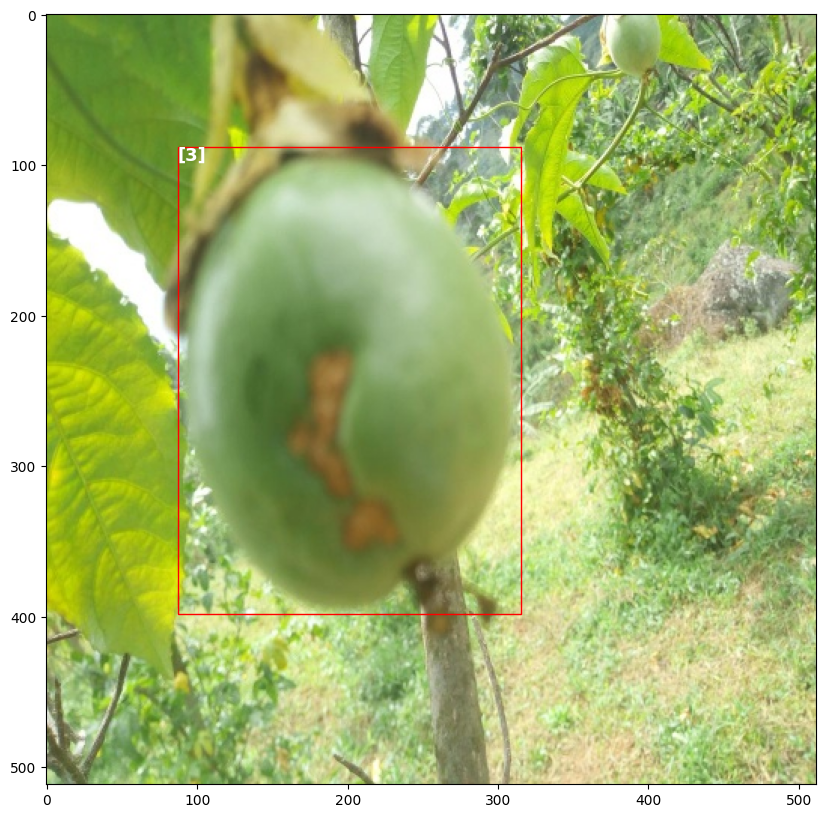

In [19]:
name = df.Image_ID.unique()[0]
plot_image(name)

      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5
      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5


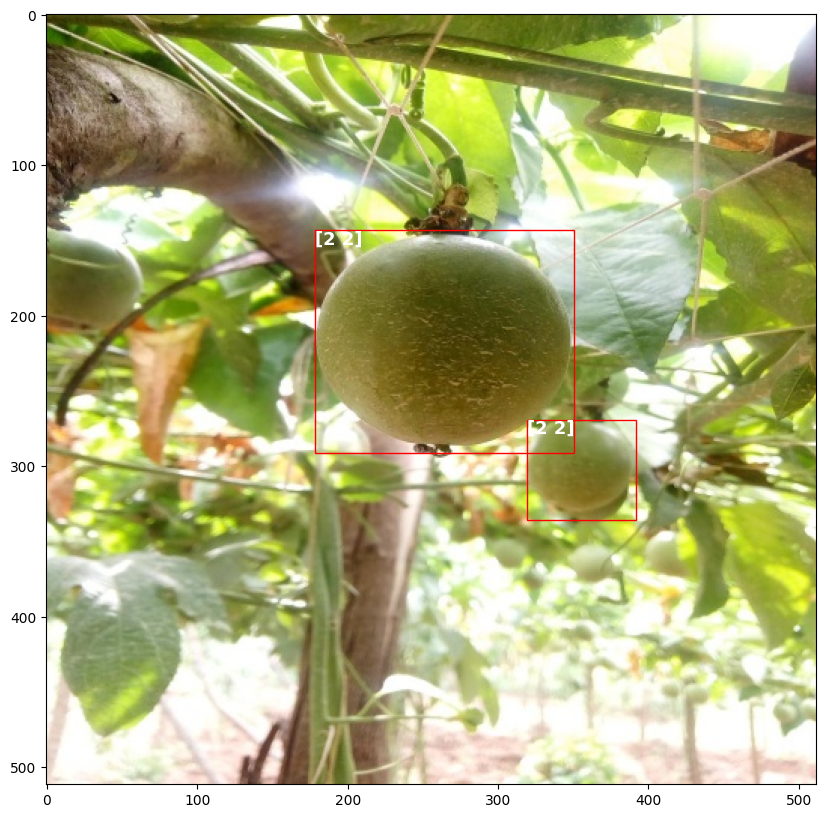

In [20]:
name = df.Image_ID.unique()[700]
plot_image(name)

     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0
     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0


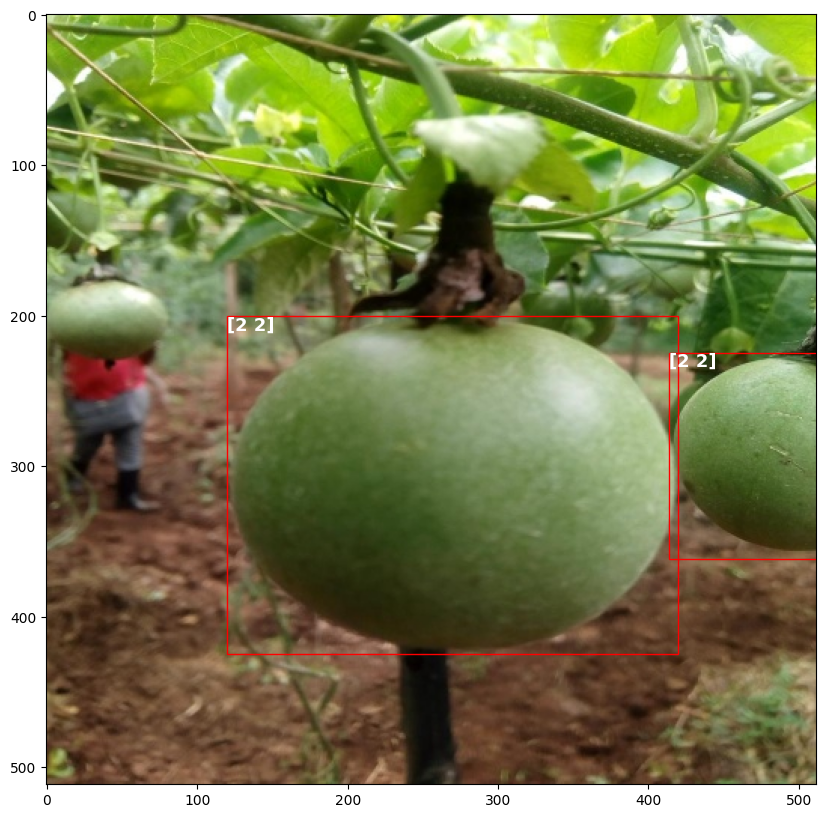

In [21]:
name = df.Image_ID.unique()[67]
plot_image(name)

## Create a custom Dataset



*     We'll create a custom dataset to load our images into PyTorch object detector.

*     Sample https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html



In [22]:
class PassionFruit(object):
    def __init__(self, df, IMG_DIR, transforms):
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique().tolist()
        self.transforms = transforms
    def __len__(self):
        return len(self.image_ids)
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)
        if self.transforms:
                sample = {
                                'image': image,
                                'bboxes': target['boxes'],
                                'labels': labels
                }
        sample = self.transforms(**sample)
        image = sample['image']
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)



        return torch.tensor(image), target

## AUGMENTATIONS

#### Remember in Our EDA we tried an augmentation pipeline, now we
#### define the image transformations. We'll use albumentations package: https://albumentations.ai/

In [23]:
def get_train_transform():
    return A.Compose([
            A.Resize(512, 512), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ), 
#             A.RandomBrightness(),
#             A.RandomContrast(),
            
#             A.RandomGamma(),        
#             A.Downscale(),
#             A.Blur(),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## load passion fruit dataset and perform the transormations

In [24]:
passion_dataset = PassionFruit(df, path, get_train_transform())

## Check if the custom dataset object created ealier works

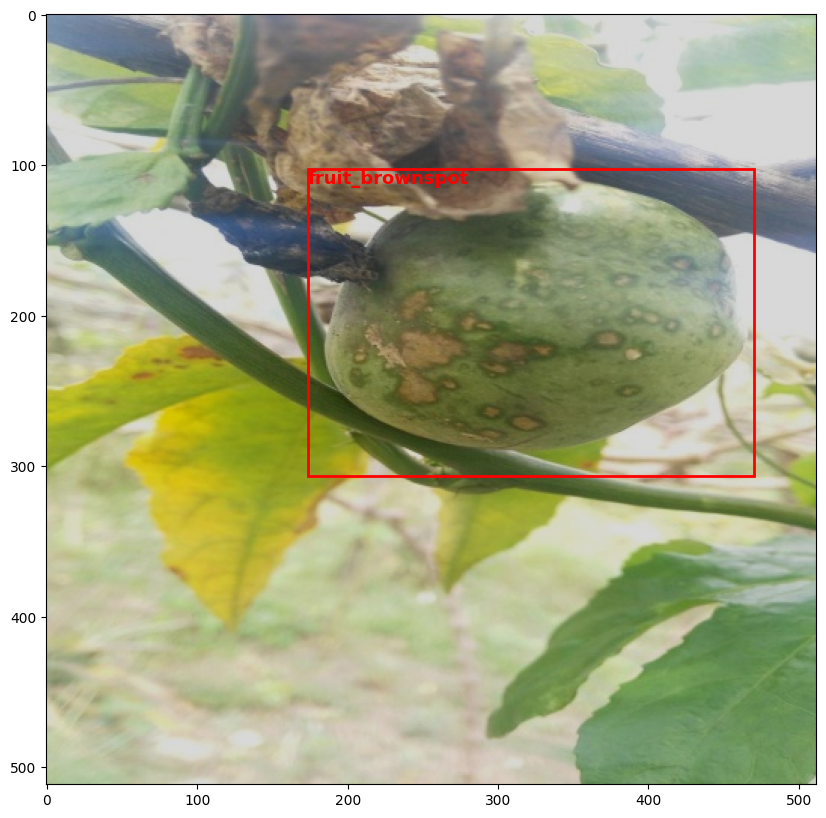

In [25]:
img, tar= passion_dataset[random.randint(0,1000)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"fruit_brownspot",  2:"fruit_healthy", 3:"fruit_woodiness"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


## Splitting Data into Train and Test Data

In [26]:
# image_ids = df['Image_ID'].unique()
# valid_ids = image_ids[-665:]
# train_ids = image_ids[:-665]
# valid_df = df[df['Image_ID'].isin(valid_ids)]
# train_df = df[df['Image_ID'].isin(train_ids)]
# train_df.shape,valid_df.shape

In [27]:
# df_train = df.copy()

In [28]:
# df_train["tfrecord"] = -1

In [29]:
# df_train.head()

In [30]:
# y=df_train['class'].values

In [31]:

# kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train,y=y)):
#     df_train.loc[valid_indicies, "tfrecord"] = fold

In [32]:
# df_train['tfrecord'].value_counts()

In [33]:
# df_train.to_csv("train_folds5.csv", index=False)

In [34]:

def get_train_val_split(df):
    #Remove Duplicates
    df = df[df.tfrecord != -1].reset_index(drop=True)
    #We are splitting data based on singlestratified kernel provided above
    df['class_Fold'] = df['class'].astype(str) + df['tfrecord'].astype(str)
    train_df, valid_df = model_selection.train_test_split(df, test_size=0.2, random_state=0, stratify=df[['class_Fold']])

    return train_df,valid_df

In [35]:
df = pd.read_csv("../input/makerere-fruit-passion/train_folds5.csv")
train_df,valid_df = get_train_val_split(df)
train_df.shape,valid_df.shape

((3124, 10), (782, 10))

In [36]:
valid_df.head()

Image_ID  class   xmin   ymin  width  height   xmax   ymax  tfrecord  \
762   ID_6T0W6C3E      2  168.5  211.0  219.5   173.5  388.0  384.5         4   
771   ID_6WAGAOIA      2   53.5  158.0  296.0   241.5  349.5  399.5         4   
3563  ID_WT1CRGZL      2   82.5  134.5  134.5   105.5  217.0  240.0         3   
2673  ID_OH8420G4      3  112.0  179.0  299.5   243.5  411.5  422.5         2   
1312  ID_C11KO2RG      2    0.0    0.0  235.5   126.0  235.5  126.0         0   

     class_Fold  
762          24  
771          24  
3563         23  
2673         32  
1312         20

In [37]:

train_df['class'].value_counts()


2    1311
3     996
1     817
Name: class, dtype: int64

In [38]:

valid_df['class'].value_counts()

2    327
3    250
1    205
Name: class, dtype: int64

## DataLoader


*     PyTorch uses dataloader module to make the dataset iterable. We'll pass both the train and val set to the PyTorch DataLoader



In [39]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PassionFruit(train_df, path, get_train_transform())
valid_dataset = PassionFruit(valid_df, path, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=10,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

### Most pretrained models are trained with a background class, we'll include it in our model, so in that case our number of classes will be 4



In [40]:
num_classes = 4  # + background

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 269MB/s] 


In [41]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [42]:
num_epochs = 10

In [43]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_data_loader)*num_epochs)

## Training and Evaluation

In [44]:
from engine import train_one_epoch, evaluate
num_epochs = 10
best_epoch = 0
best_map = 0.0

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    coco_evaluator = evaluate(model, valid_data_loader, device=device)
    coco_stats = coco_evaluator.coco_eval['bbox'].stats
    mAP = coco_stats[0]  # Access mAP value from the coco_stats tuple
    
    if mAP > best_map:
        best_map = mAP
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')



print(f"Best mAP: {best_map} at epoch: {best_epoch}")


Epoch: [0]  [  0/251]  eta: 8:33:11  lr: 0.000025  loss: 1.7013 (1.7013)  loss_classifier: 1.4757 (1.4757)  loss_box_reg: 0.1569 (0.1569)  loss_objectness: 0.0600 (0.0600)  loss_rpn_box_reg: 0.0088 (0.0088)  time: 122.6765  data: 1.0687  max mem: 14667
Epoch: [0]  [ 10/251]  eta: 0:50:28  lr: 0.000225  loss: 1.6027 (1.5538)  loss_classifier: 1.4034 (1.3435)  loss_box_reg: 0.1362 (0.1448)  loss_objectness: 0.0600 (0.0586)  loss_rpn_box_reg: 0.0072 (0.0068)  time: 12.5681  data: 0.1289  max mem: 14667
Epoch: [0]  [ 20/251]  eta: 0:28:11  lr: 0.000425  loss: 1.1908 (1.1814)  loss_classifier: 0.9449 (0.9610)  loss_box_reg: 0.1558 (0.1520)  loss_objectness: 0.0627 (0.0609)  loss_rpn_box_reg: 0.0072 (0.0075)  time: 1.5526  data: 0.0376  max mem: 14667
Epoch: [0]  [ 30/251]  eta: 0:20:05  lr: 0.000624  loss: 0.4951 (0.9419)  loss_classifier: 0.2522 (0.7198)  loss_box_reg: 0.1679 (0.1646)  loss_objectness: 0.0429 (0.0508)  loss_rpn_box_reg: 0.0050 (0.0065)  time: 1.5458  data: 0.0399  max mem:

Best mAP: 0.665175297456555 at epoch: 8

The most commonly used IoU threshold for mAP calculation is 0.5, also known as mAP@0.5. This threshold is widely used in object detection benchmarks and serves as a standard metric for evaluating object detection models. It measures the accuracy of bounding box predictions by considering the overlap between predicted boxes and ground truth boxes. An IoU of 0.5 means that at least 50% of the predicted box overlaps with the ground truth box.

In addition to mAP@0.5, other IoU thresholds such as 0.75 or a range from 0.5 to 0.95 can also be considered. These thresholds provide a more stringent evaluation by requiring higher overlap between predicted and ground truth boxes. Higher IoU thresholds can be useful in applications where precise localization of objects is crucial or when there is a need to reduce false positives.

##0.734161579 - 0.7304699650007127

## Sample evaluation on validation dataset image

In [45]:
img,target = valid_dataset[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))

print('real #boxes: ', len(target['boxes']))

predicted #boxes:  3
real #boxes:  1


In [46]:
prediction

{'boxes': tensor([[136.7423, 207.6644, 428.2083, 433.7947],
         [  0.0000, 359.4888, 109.0123, 512.0000],
         [140.2329, 200.2134, 438.1418, 437.5949]], device='cuda:0'),
 'labels': tensor([2, 2, 1], device='cuda:0'),
 'scores': tensor([0.9817, 0.9337, 0.1111], device='cuda:0')}

## ground truth box for the sample test

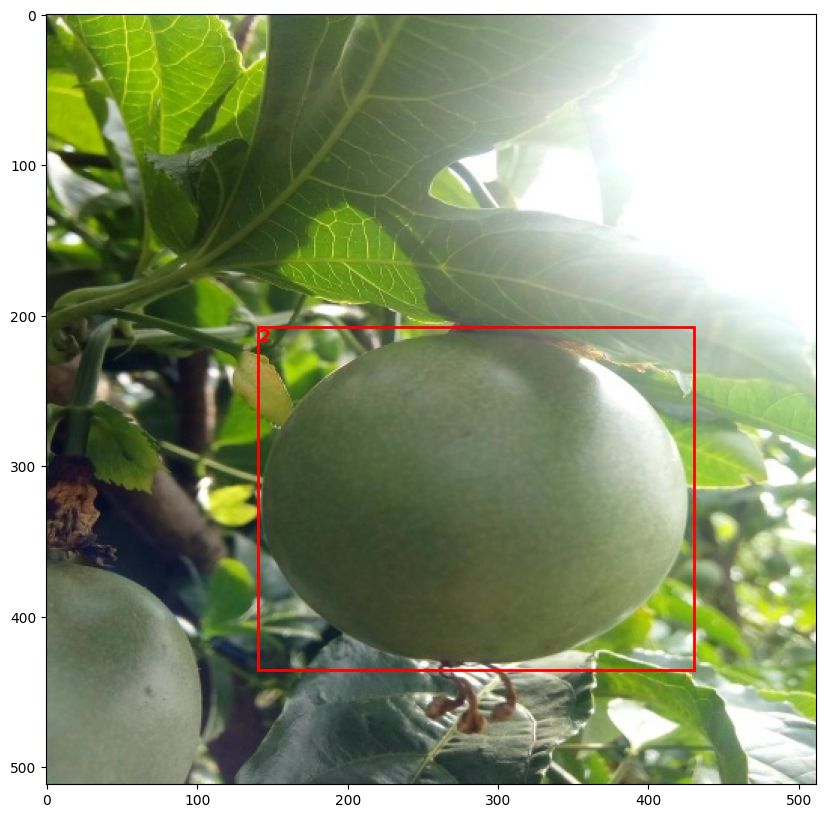

In [47]:
bbox = target['boxes'].numpy()
fig,ax = plt.subplots(1,figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in target["labels"]:
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l.tolist(), verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

## Predicted box for the sample Image

In [48]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = img.permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    for l in target["labels"]:
        for i in range(len(bbox)):
            if val_scores[i]>=detect_thresh:
                box = bbox[i]
                x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
                rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
                ax.text(*box[:2], "class " + str(l.tolist()) + " score {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
                ax.add_patch(rect)
        plt.show()

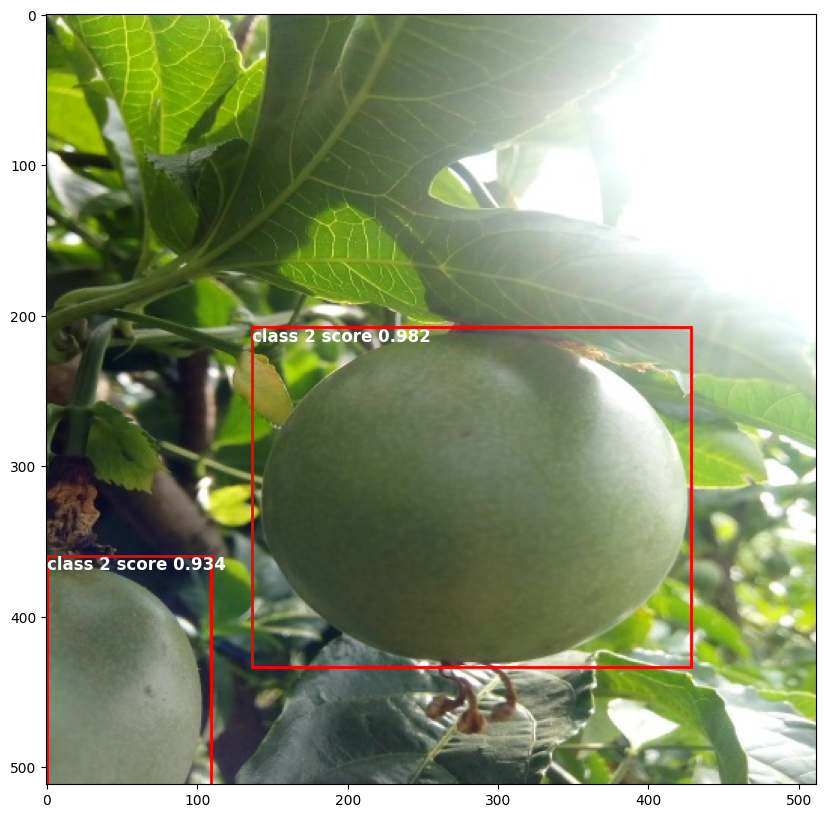

In [49]:
plot_valid(img,prediction)

## Load the Submission Files

In [50]:
import torch
import torchvision.transforms as transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
# !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg


In [51]:
submission = pd.read_csv('../input/makerere-fruit-passion/New Makerere/New Makerere/Test.csv')

In [52]:
class TestDataset(object):
    def __init__(self, df, IMG_DIR, transforms):        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['Image_ID'].tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):        
        image_id = self.image_ids[idx]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

In [53]:
class One_Image(object):
    def __init__(self,IMG_PATH, transforms):        
        
        self.img_path = IMG_PATH
        self.transforms = transforms

    
    def __getitem__(self, idx=0):        
        image = cv2.imread(self.img_path,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
        return image

In [54]:
def get_test_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE),
        ToTensorV2(p=1.0)
    ])

In [55]:
test_img_dir = '../input/makerere-fruit-passion/New Makerere/New Makerere/Test_Images(1)/Test_Images/'
test_img_path = '../input/makerere-fruit-passion/New Makerere/New Makerere/Test_Images(1)/Test_Images/ID_14EC1H1R.jpg'

In [56]:
IMG_SIZE = (512,512)

In [57]:
test_dataset = TestDataset(submission, test_img_dir ,get_test_transform())


In [107]:
one_dataset = One_Image('../input/makerere-fruit-passion/New Makerere/New Makerere/Test_Images(1)/Test_Images/ID_Q0DC3D7Q.jpg', get_test_transform())
one_dataset

In [108]:
def load_saved_fasterrcnn_model_(model_path, num_classes):
    # Load the pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=False)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load the saved model weights
    model.load_state_dict(torch.load(model_path))
  
    # Set the model in evaluation mode
    model.eval()

    return model

# Example usage:
model_path = '/kaggle/working/best_model.pth'
num_classes = 4
model = load_saved_fasterrcnn_model_(model_path, num_classes)


In [109]:
img = one_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))

predicted #boxes:  3


In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_valid(img, prediction, nms=True, detect_thresh=0.5):
    fig, ax = plt.subplots(figsize=(18, 10))
    val_img = img.permute(1, 2, 0).cpu().numpy()
    ax.imshow(val_img)

    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    labels = prediction['labels'].tolist()

    if nms:
        keep = nms_bbox(bbox, val_scores)
        bbox = bbox[keep]
        val_scores = val_scores[keep]
        labels = [labels[i] for i in keep]

    classes_labels = {1: "fruit_brownspot", 2: "fruit_healthy", 3: "fruit_woodiness"}

    for label, box, score in zip(labels, bbox, val_scores):
        if score < detect_thresh:
            continue

        x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.text(x, y, classes_labels[label], verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)

    plt.show()

def nms_bbox(boxes, scores, iou_thresh=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to eliminate overlapping bounding boxes.
    :param boxes: Array of bounding boxes in the format [x1, y1, x2, y2].
    :param scores: Array of corresponding confidence scores for each bounding box.
    :param iou_thresh: IoU threshold for overlapping bounding boxes.
    :return: Array of indices to keep after NMS.
    """
    if len(boxes) == 0:
        return []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while len(order) > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(iou <= iou_thresh)[0]
        order = order[inds + 1]

    return keep


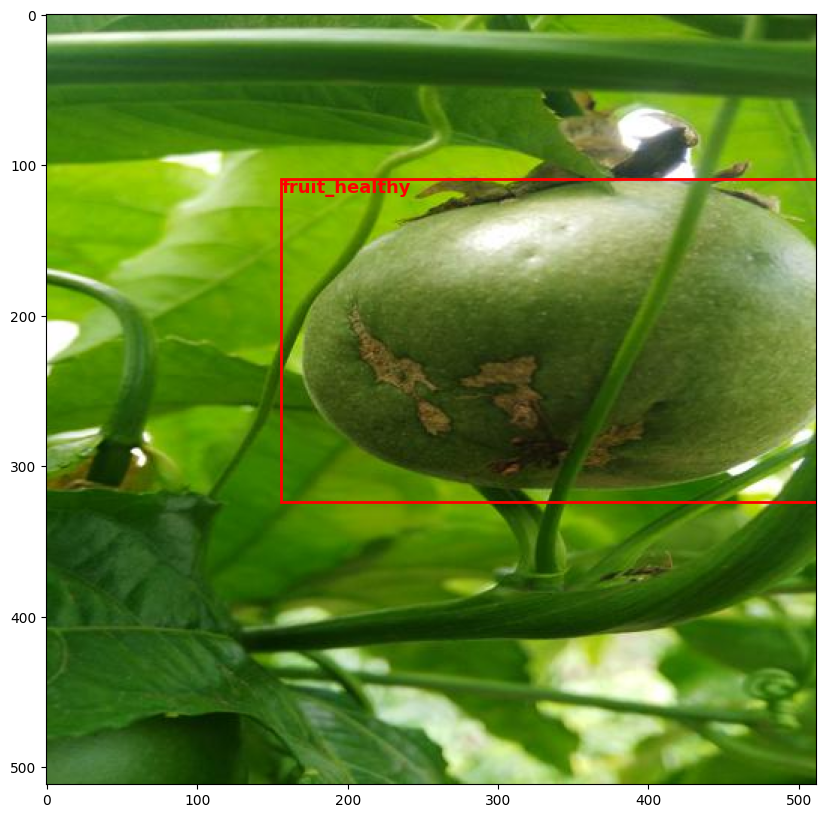

In [124]:
plot_valid(img, prediction)

In [104]:
results = []


img = one_dataset[0]
img = img.unsqueeze_(0)


with torch.no_grad():
    prediction = model([img][0])
    aa = zip(prediction[0]["boxes"].tolist(), prediction[0]["labels"].tolist(), prediction[0]["scores"].tolist())

    for item in list(aa):
        row_dict = {}
        row_dict["Image_ID"] = _
        row_dict["boxes"] = item[0]
        row_dict["labels"] = item[1]
        row_dict["confidence"] = item[2]
        results.append(row_dict)
sub_df = pd.DataFrame(results)
print(prediction)

[{'boxes': tensor([[155.8536, 108.7849, 512.0000, 323.9978],
        [162.5740, 105.7903, 512.0000, 320.0529],
        [160.2273,  95.6940, 512.0000, 326.7403]]), 'labels': tensor([2, 3, 1]), 'scores': tensor([0.7912, 0.5942, 0.1369])}]


In [126]:

results = []

img = one_dataset[0]
img = img.unsqueeze_(0)

with torch.no_grad():
    prediction = model([img][0])
    bbox = np.array(prediction[0]["boxes"].tolist())
    labels = prediction[0]["labels"].tolist()
    scores = np.array(prediction[0]["scores"].tolist())

    if len(bbox) > 0:
        keep = nms_bbox(bbox, scores)
        bbox = bbox[keep]
        labels = [labels[i] for i in keep]
        scores = scores[keep]

    for b, l, s in zip(bbox, labels, scores):
        row_dict = {}
        row_dict["Image_ID"] = _
        row_dict["boxes"] = b
        row_dict["labels"] = l
        row_dict["confidence"] = s
        results.append(row_dict)

sub_df = pd.DataFrame(results)



[{'boxes': tensor([[155.8536, 108.7849, 512.0000, 323.9978],
        [162.5740, 105.7903, 512.0000, 320.0529],
        [160.2273,  95.6940, 512.0000, 326.7403]]), 'labels': tensor([2, 3, 1]), 'scores': tensor([0.7912, 0.5942, 0.1369])}]


In [127]:
sub_df

Image_ID                                              boxes  labels  \
0  ID_HP4JUAS0  [155.8535919189453, 108.78488159179688, 512.0,...       2   

   confidence  
0    0.791166

In [128]:
sub_df["ymin"] = sub_df["boxes"].apply(lambda x: x[1])
sub_df["xmin"] = sub_df["boxes"].apply(lambda x: x[0])
sub_df["ymax"] = sub_df["boxes"].apply(lambda x: x[3])
sub_df["xmax"]=  sub_df["boxes"].apply(lambda x: x[2])

In [129]:
classes_la = {0:"Background", 1:"fruit_brownspot", 2:"fruit_healthy", 3:"fruit_woodiness"}
sub_df["labels"] = sub_df["labels"].apply(lambda x: classes_la[x])

In [130]:
sub_df.drop(["boxes"], axis=1, inplace=True)
sub_df.rename(columns={"labels":"class"}, inplace=True)
sub_df.head()

Image_ID          class  confidence        ymin        xmin        ymax  \
0  ID_HP4JUAS0  fruit_healthy    0.791166  108.784882  155.853592  323.997772   

    xmax  
0  512.0

In [131]:
sub_df.shape

(1, 7)

In [132]:
sub_df.to_csv("new.csv", index=False)

### Submission

In [133]:


results = []
score_threshold = 0.5  # Set your desired score threshold here

for j in range(submission.shape[0]):
    img, _ = test_dataset[j]
    img = img.unsqueeze_(0)
    model.eval()

    with torch.no_grad():
        prediction = model([img][0])
        bbox = np.array(prediction[0]["boxes"].tolist())
        labels = prediction[0]["labels"].tolist()
        scores = np.array(prediction[0]["scores"].tolist())

        if len(bbox) > 0:
            keep = nms_bbox(bbox, scores)
            bbox = bbox[keep]
            labels = [labels[i] for i in keep]
            scores = scores[keep]

        for b, l, s in zip(bbox, labels, scores):
            if s >= score_threshold:  # Check if the score meets the threshold
                row_dict = {}
                row_dict["Image_ID"] = _
                row_dict["boxes"] = b
                row_dict["labels"] = l
                row_dict["confidence"] = s
                results.append(row_dict)

sub_df = pd.DataFrame(results)


In [134]:
sub_df["ymin"] = sub_df["boxes"].apply(lambda x: x[1])
sub_df["xmin"] = sub_df["boxes"].apply(lambda x: x[0])
sub_df["ymax"] = sub_df["boxes"].apply(lambda x: x[3])
sub_df["xmax"]=  sub_df["boxes"].apply(lambda x: x[2])

In [135]:
classes_la = {0:"Background", 1:"fruit_brownspot", 2:"fruit_healthy", 3:"fruit_woodiness"}
sub_df["labels"] = sub_df["labels"].apply(lambda x: classes_la[x])

In [136]:
sub_df.drop(["boxes"], axis=1, inplace=True)
sub_df.rename(columns={"labels":"class"}, inplace=True)
sub_df.head()

Image_ID          class  confidence        ymin        xmin        ymax  \
0  ID_IUJJG62B  fruit_healthy    0.992673  150.909180   73.728416  400.927094   
1  ID_IUJJG62B  fruit_healthy    0.965234  317.322601  284.206055  477.571777   
2  ID_ZPNDRD4T  fruit_healthy    0.975443  228.502457  123.771446  375.997253   
3  ID_ZPNDRD4T  fruit_healthy    0.876383  357.209747  462.746307  512.000000   
4  ID_ZPNDRD4T  fruit_healthy    0.593668  298.577698  105.767555  386.272369   

         xmax  
0  374.722717  
1  476.938507  
2  313.311432  
3  512.000000  
4  218.525909

In [137]:
sub_df.to_csv("nms_sub.csv", index=False)